# Stepik ML contest

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score, plot_roc_curve, plot_precision_recall_curve, ConfusionMatrixDisplay, confusion_matrix

In [566]:
events_train = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip')
events_train.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [3]:
# description
# step_id - id стэпа
# user_id - анонимизированный id юзера
# timestamp - время наступления события в формате unix date
# action - событие, возможные значения:
# discovered - пользователь перешел на стэп
# viewed - просмотр шага,
# started_attempt - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага
# passed - удачное решение практического шага

In [567]:
submissions_train = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip')
submissions_train.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [5]:
# description
# step_id - id стэпа
# timestamp - время отправки решения в формате unix date
# submission_status - статус решения
# user_id - анонимизированный id юзера

### Data preparation

In [568]:
events_train['date'] = pd.to_datetime(events_train.timestamp, unit='s')

In [569]:
events_train['day'] = events_train.date.dt.date
events_train.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


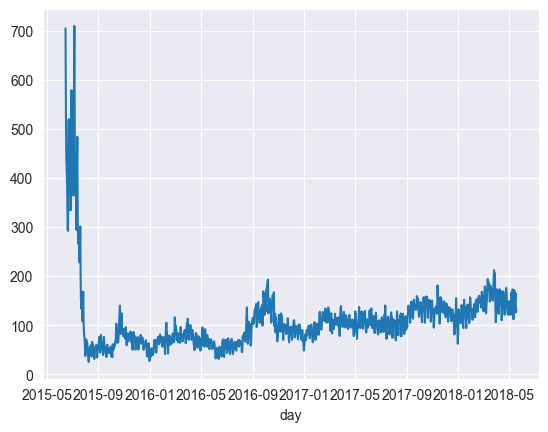

In [173]:
# считаем кол-во уникальных пользователей
events_train.groupby('day')['user_id'].nunique().plot()
plt.show()

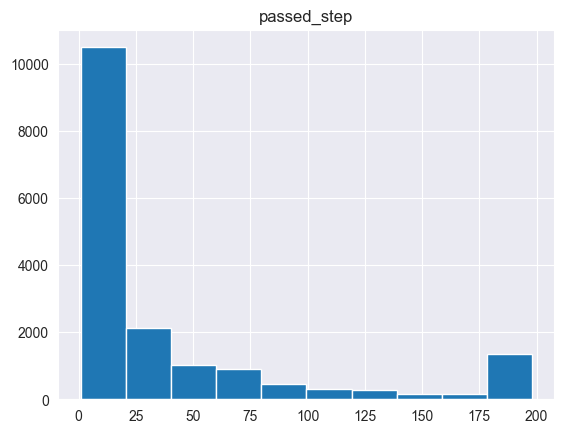

In [8]:
events_train[events_train.action == 'passed'].groupby('user_id').aggregate({'step_id': 'count'}).rename(columns={'step_id': 'passed_step'}).hist()
plt.show()

In [175]:
events_train.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index().head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


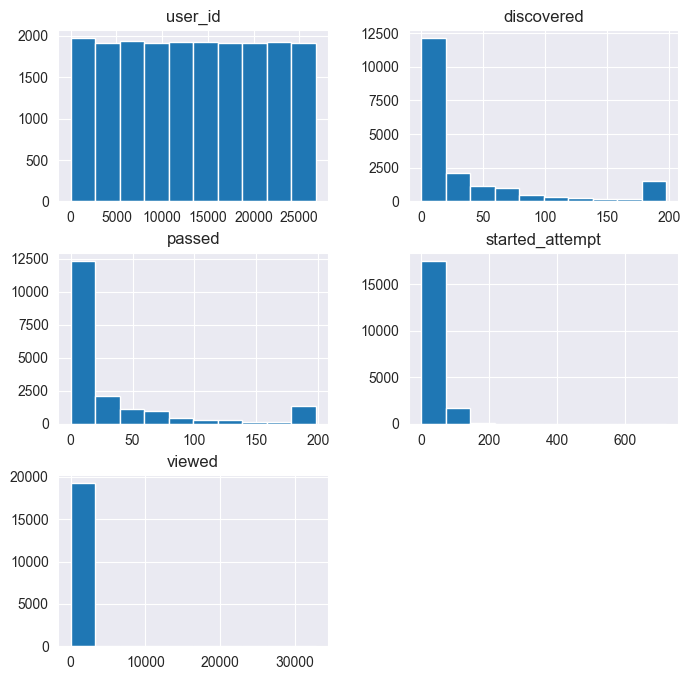

In [176]:
events_train.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index().hist(figsize=(8, 8))
plt.show()

In [570]:
submissions_train['date'] = pd.to_datetime(submissions_train.timestamp, unit='s')
submissions_train.head()

,step_id,timestamp,submission_status,user_id,date
0,31971,1434349275,correct,15853,2015-06-15 06:21:15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49
3,31972,1478852164,correct,15853,2016-11-11 08:16:04
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03


In [571]:
submissions_train['day'] = submissions_train.date.dt.date
submissions_train.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [179]:
submissions_train.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0).reset_index().head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


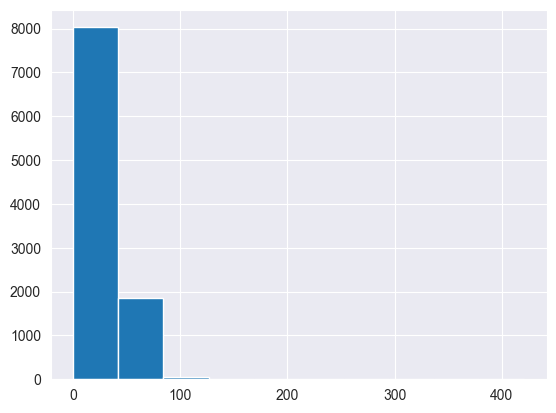

In [180]:
submissions_train.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0).reset_index().correct.hist()
plt.show()

### Задача
Отсечь пользователей, которые не закончили курс. Допустим, если пользователь не возвращался к курсу какое-то время, то с высокой вероятностью он уже не вернется для завершения курса.

**Шаг 1**
Найдем временные промежутки между прохождением степов, далее посмотрим в какой интервал укладывается большинство пользователей.

In [572]:
# для работы нам потребуется 3 колонки
visits_gap = events_train[['user_id', 'day', 'timestamp']]
visits_gap.head()

,user_id,day,timestamp
0,17632,2015-06-15,1434340848
1,17632,2015-06-15,1434340848
2,17632,2015-06-15,1434340848
3,17632,2015-06-15,1434340895
4,17632,2015-06-15,1434340895


In [573]:
# оставляем только уникальные записи timestamp в рамках одного пользователя и дня
visits_gap = visits_gap.drop_duplicates(subset=['user_id', 'day'])
visits_gap.head()

,user_id,day,timestamp
0,17632,2015-06-15,1434340848
36,12494,2015-06-15,1434341931
59,442,2015-06-15,1434342029
62,22254,2015-06-15,1434342042
94,6646,2015-06-15,1434342230


In [574]:
# создаем список с timestamp действий пользователя
visits_gap = visits_gap.groupby('user_id')['timestamp'].apply(list)
visits_gap.head()

user_id
1                                         [1472827464]
2                             [1514383364, 1519226966]
3    [1434358476, 1441257725, 1441440209, 144153391...
5                             [1466156809, 1499859621]
7                                         [1521634660]
Name: timestamp, dtype: object

In [575]:
# считаем разницу между событиями
visits_gap = visits_gap.apply(np.diff)
visits_gap.head()

user_id
1                                                  []
2                                           [4843602]
3    [6899249, 182484, 93710, 2768870, 171400, 78712]
5                                          [33702812]
7                                                  []
Name: timestamp, dtype: object

In [576]:
# извлекаем из серии значения
visits_gap = visits_gap.values
visits_gap

array([array([], dtype=int64), array([4843602]),
       array([6899249,  182484,   93710, 2768870,  171400,   78712]), ...,
       array([   86128,   136759,    94899,  1422583, 14347289,   505061,
                 98252,    57019])                                       ,
       array([1567990]), array([], dtype=int64)], dtype=object)

In [577]:
# трансформируем события в плоский список
visits_gap = pd.Series(np.concatenate(visits_gap, axis=0))
visits_gap

0         4843602
1         6899249
2          182484
3           93710
4         2768870
           ...   
97867    14347289
97868      505061
97869       98252
97870       57019
97871     1567990
Length: 97872, dtype: int64

In [578]:
# меняем формат в дни
visits_gap = visits_gap / (24 * 60 * 60)

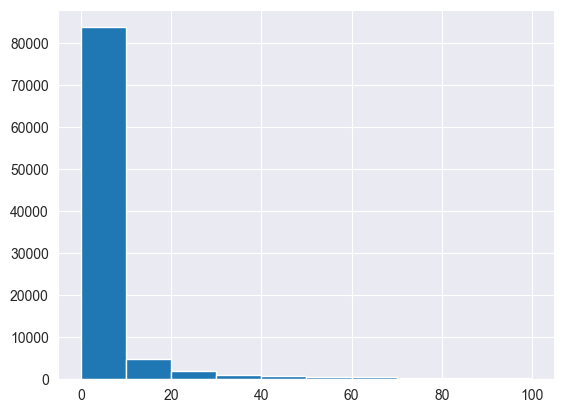

In [261]:
# строим гистограмму
visits_gap[visits_gap < 100].hist()
plt.show()

In [262]:
# смотрим в какой интервал времени укладывается 90% событий
visits_gap.quantile(0.90)

18.325995370370403

In [579]:
is_gone_time_gap = visits_gap.quantile(0.90)

**Шаг 2**
Смержим наши данные в таблицу и дополним ее необходимыми значениями

In [580]:
events_pivot = events_train.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index()
events_pivot.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [581]:
submissions_pivot = submissions_train.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0).reset_index()
submissions_pivot.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [582]:
users_data = events_pivot.merge(submissions_pivot, on='user_id', how='outer')
users_data = users_data.fillna(0)
users_data.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong
0,1,1,0,0,1,0.0,0.0
1,2,9,9,2,10,2.0,0.0
2,3,91,87,30,192,29.0,23.0
3,5,11,11,4,12,2.0,2.0
4,7,1,1,0,1,0.0,0.0


In [583]:
last_timestamp = events_train[['user_id','timestamp']].groupby('user_id').aggregate({'timestamp':'max'}).reset_index().rename(columns={'timestamp': 'last_timestamp'})

In [584]:
last_timestamp.head()

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660


In [585]:
users_data = users_data.merge(last_timestamp, on='user_id', how='outer').fillna(0)
users_data.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,last_timestamp
0,1,1,0,0,1,0.0,0.0,1472827464
1,2,9,9,2,10,2.0,0.0,1519226966
2,3,91,87,30,192,29.0,23.0,1444581588
3,5,11,11,4,12,2.0,2.0,1499859939
4,7,1,1,0,1,0.0,0.0,1521634660


In [586]:
now_t = users_data.last_timestamp.max()
now_t

1526772811

In [587]:
users_data['is_gone'] = now_t - users_data['last_timestamp']  > is_gone_time_gap
users_data.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,last_timestamp,is_gone
0,1,1,0,0,1,0.0,0.0,1472827464,True
1,2,9,9,2,10,2.0,0.0,1519226966,True
2,3,91,87,30,192,29.0,23.0,1444581588,True
3,5,11,11,4,12,2.0,2.0,1499859939,True
4,7,1,1,0,1,0.0,0.0,1521634660,True


In [272]:
users_data['course_completed'] = users_data.passed > 170
users_data.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,last_timestamp,is_gone,course_completed
0,1,1,0,0,1,0.0,0.0,1472827464,True,False
1,2,9,9,2,10,2.0,0.0,1519226966,True,False
2,3,91,87,30,192,29.0,23.0,1444581588,True,False
3,5,11,11,4,12,2.0,2.0,1499859939,True,False
4,7,1,1,0,1,0.0,0.0,1521634660,True,False


In [1073]:
users_data['course_completed'] = users_data.passed > 40
users_data.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,last_timestamp,is_gone,course_completed,first_timestamp_x,completion_time,first_timestamp_y,first_timestamp
0,1,1,0,0,1,0.0,0.0,1472827464,True,False,1472827464,0.000000e+00,1472827464,1472827464
1,2,9,9,2,10,2.0,0.0,1519226966,True,False,1514383364,7.265403e+08,1514383364,1514383364
2,3,91,87,30,192,29.0,23.0,1444581588,True,True,1434358476,1.533467e+09,1434358476,1434358476
3,5,11,11,4,12,2.0,2.0,1499859939,True,False,1466156809,5.055470e+09,1466156809,1466156809
4,7,1,1,0,1,0.0,0.0,1521634660,True,False,1521634660,0.000000e+00,1521634660,1521634660


In [1074]:
users_data.groupby('course_completed')['course_completed'].count()

course_completed
False    14596
True      4638
Name: course_completed, dtype: int64

In [1075]:
users_data

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,last_timestamp,is_gone,course_completed,first_timestamp_x,completion_time,first_timestamp_y,first_timestamp
0,1,1,0,0,1,0.0,0.0,1472827464,True,False,1472827464,0.000000e+00,1472827464,1472827464
1,2,9,9,2,10,2.0,0.0,1519226966,True,False,1514383364,7.265403e+08,1514383364,1514383364
2,3,91,87,30,192,29.0,23.0,1444581588,True,True,1434358476,1.533467e+09,1434358476,1434358476
3,5,11,11,4,12,2.0,2.0,1499859939,True,False,1466156809,5.055470e+09,1466156809,1466156809
4,7,1,1,0,1,0.0,0.0,1521634660,True,False,1521634660,0.000000e+00,1521634660,1521634660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,8,8,1,9,1.0,0.0,1517495987,True,False,1451484016,9.901796e+09,1451484016,1451484016
19230,26793,1,0,1,1,0.0,0.0,1510225034,True,False,1510225031,4.500000e+02,1510225031,1510225031
19231,26794,69,69,34,180,33.0,9.0,1512035039,True,True,1495287049,2.512198e+09,1495287049,1495287049
19232,26797,10,10,2,13,2.0,0.0,1509995096,True,False,1508425316,2.354670e+08,1508425316,1508425316


### Задача
Предсказать успешность прохождения курса на основе поведения студента в первые несколько дней

In [201]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19234 entries, 0 to 19233
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           19234 non-null  int64  
 1   discovered        19234 non-null  int64  
 2   passed            19234 non-null  int64  
 3   started_attempt   19234 non-null  int64  
 4   viewed            19234 non-null  int64  
 5   correct           19234 non-null  float64
 6   wrong             19234 non-null  float64
 7   last_timestamp    19234 non-null  int64  
 8   is_gone           19234 non-null  bool   
 9   course_completed  19234 non-null  bool   
dtypes: bool(2), float64(2), int64(6)
memory usage: 1.4 MB


In [202]:
users_data.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,last_timestamp,is_gone,course_completed
0,1,1,0,0,1,0.0,0.0,1472827464,True,False
1,2,9,9,2,10,2.0,0.0,1519226966,True,False
2,3,91,87,30,192,29.0,23.0,1444581588,True,False
3,5,11,11,4,12,2.0,2.0,1499859939,True,False
4,7,1,1,0,1,0.0,0.0,1521634660,True,False


In [691]:
first_timestamp = events_train.groupby('user_id').aggregate({'timestamp': 'min'}).reset_index().rename(columns={'timestamp': 'first_timestamp'})

In [692]:
first_timestamp.head()

,user_id,first_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [693]:
users_data = users_data.merge(first_timestamp, on='user_id', how='outer').fillna(0)

In [694]:
users_data.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,last_timestamp,is_gone,course_completed,first_timestamp_x,completion_time,first_timestamp_y,first_timestamp
0,1,1,0,0,1,0.0,0.0,1472827464,True,False,1472827464,0.000000e+00,1472827464,1472827464
1,2,9,9,2,10,2.0,0.0,1519226966,True,False,1514383364,7.265403e+08,1514383364,1514383364
2,3,91,87,30,192,29.0,23.0,1444581588,True,True,1434358476,1.533467e+09,1434358476,1434358476
3,5,11,11,4,12,2.0,2.0,1499859939,True,False,1466156809,5.055470e+09,1466156809,1466156809
4,7,1,1,0,1,0.0,0.0,1521634660,True,False,1521634660,0.000000e+00,1521634660,1521634660


In [695]:
users_data['completion_time'] = (users_data.last_timestamp - users_data.first_timestamp_x) / 24 * 60 * 60
users_data.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,last_timestamp,is_gone,course_completed,first_timestamp_x,completion_time,first_timestamp_y,first_timestamp
0,1,1,0,0,1,0.0,0.0,1472827464,True,False,1472827464,0.000000e+00,1472827464,1472827464
1,2,9,9,2,10,2.0,0.0,1519226966,True,False,1514383364,7.265403e+08,1514383364,1514383364
2,3,91,87,30,192,29.0,23.0,1444581588,True,True,1434358476,1.533467e+09,1434358476,1434358476
3,5,11,11,4,12,2.0,2.0,1499859939,True,False,1466156809,5.055470e+09,1466156809,1466156809
4,7,1,1,0,1,0.0,0.0,1521634660,True,False,1521634660,0.000000e+00,1521634660,1521634660


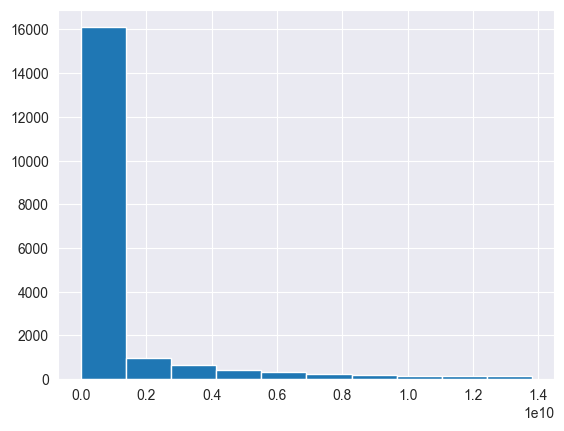

In [696]:
users_data['completion_time'].hist()
plt.show()

In [697]:
events_threshold = 2 * 24 * 60 * 60

In [611]:
# Создаем новую таблицу с событиями за первый 3 дня с первого события пользователя
events_train_first_3_days = events_train.merge(users_data[['user_id', 'first_timestamp']], on='user_id', how='left') \
    .query("(timestamp - first_timestamp) < @events_threshold")

KeyError: "['first_timestamp'] not in index"

In [751]:
events_train_first_2_days = events_train.merge(users_data[['user_id', 'first_timestamp_y']], on='user_id', how='left') \
    .query("(timestamp - first_timestamp_y) < @events_threshold")

In [752]:
events_train_first_2_days.head()

,step_id,timestamp,action,user_id,date,day,first_timestamp_y
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848


In [212]:
events_train_first_3_days.shape

(1014980, 7)

In [699]:
events_train_first_2_days.groupby('user_id').day.nunique().max()

3

In [754]:
train_data = events_train_first_2_days.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index()
train_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,9
2,3,15,15,4,20
3,5,1,1,0,1
4,7,1,1,0,1


In [755]:
train_data = train_data.merge(submissions_pivot, on='user_id', how='outer').fillna(0)
train_data.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong
0,1,1,0,0,1,0.0,0.0
1,2,9,9,2,9,2.0,0.0
2,3,15,15,4,20,29.0,23.0
3,5,1,1,0,1,2.0,2.0
4,7,1,1,0,1,0.0,0.0


In [1088]:
train_data.user_id

0            1
1            2
2            3
3            5
4            7
         ...  
19229    26790
19230    26793
19231    26794
19232    26797
19233    26798
Name: user_id, Length: 19233, dtype: int64

In [757]:
last_timestamp = events_train[['user_id', 'timestamp']].groupby('user_id').aggregate(
    {'timestamp': 'max'}).reset_index().rename(columns={'timestamp': 'last_timestamp'})
last_timestamp.head()

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660


In [758]:
train_data = train_data.merge(last_timestamp, on='user_id', how='outer').fillna(0)
train_data.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,last_timestamp
0,1,1,0,0,1,0.0,0.0,1472827464
1,2,9,9,2,9,2.0,0.0,1519226966
2,3,15,15,4,20,29.0,23.0,1444581588
3,5,1,1,0,1,2.0,2.0,1499859939
4,7,1,1,0,1,0.0,0.0,1521634660


In [759]:
now_t = users_data.last_timestamp.max()
now_t

1526772811

In [760]:
train_data['is_gone'] = now_t - train_data['last_timestamp'] > is_gone_time_gap
train_data.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,last_timestamp,is_gone
0,1,1,0,0,1,0.0,0.0,1472827464,True
1,2,9,9,2,9,2.0,0.0,1519226966,True
2,3,15,15,4,20,29.0,23.0,1444581588,True
3,5,1,1,0,1,2.0,2.0,1499859939,True
4,7,1,1,0,1,0.0,0.0,1521634660,True


In [761]:
train_data = train_data.merge(users_data[['user_id', 'course_completed']], on='user_id', how='outer').fillna(0)
train_data.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,last_timestamp,is_gone,course_completed
0,1,1,0,0,1,0.0,0.0,1472827464,True,False
1,2,9,9,2,9,2.0,0.0,1519226966,True,False
2,3,15,15,4,20,29.0,23.0,1444581588,True,False
3,5,1,1,0,1,2.0,2.0,1499859939,True,False
4,7,1,1,0,1,0.0,0.0,1521634660,True,False


In [762]:
users_data.groupby(['is_gone', 'course_completed']).aggregate({'user_id': 'count'})

user_id
is_gone course_completed         
False   False                   1
True    False               17265
        True                 1968

In [763]:
train_data = train_data.query("is_gone == True")

In [764]:
train_data.groupby(['is_gone', 'course_completed']).aggregate({'user_id': 'count'})

user_id
is_gone course_completed         
True    False               17265
        True                 1968

In [765]:
train_data.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,last_timestamp,is_gone,course_completed
0,1,1,0,0,1,0.0,0.0,1472827464,True,False
1,2,9,9,2,9,2.0,0.0,1519226966,True,False
2,3,15,15,4,20,29.0,23.0,1444581588,True,False
3,5,1,1,0,1,2.0,2.0,1499859939,True,False
4,7,1,1,0,1,0.0,0.0,1521634660,True,False


In [712]:
X = train_data.drop(['last_timestamp', 'is_gone', 'course_completed'], axis=1)

In [713]:
X = X.set_index('user_id')
X.head()

,discovered,passed,started_attempt,viewed,correct,wrong
user_id,,,,,,
1,1,0,0,1,0.0,0.0
2,9,9,2,9,2.0,0.0
3,15,15,4,20,29.0,23.0
5,1,1,0,1,2.0,2.0
7,1,1,0,1,0.0,0.0


In [274]:
y = train_data[['user_id', 'course_completed']]

In [275]:
y = y.set_index('user_id')

In [280]:
rs = np.random.seed(0)

In [281]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = rs)

In [282]:
clf = DecisionTreeClassifier()

In [283]:
params={'criterion':['gini', 'entropy'], 'max_depth': range(1, 12)}

In [284]:
grid_search_cv_clf=GridSearchCV(clf, params, cv=5)

In [285]:
grid_search_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 12)})

In [286]:
best_clf = grid_search_cv_clf.best_estimator_
best_clf

DecisionTreeClassifier(max_depth=1)

In [293]:
grid_search_cv_clf.best_params_

{'criterion': 'gini', 'max_depth': 1}

In [317]:
best_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=1)

In [318]:
best_clf.score(X_test, y_test)

0.991890205864005

In [319]:
y_pred = best_clf.predict(X_test)

In [320]:
# проверяем Precision
precision_score(y_test, y_pred)

0.9086161879895561

In [321]:
# проверяем Recall
recall_score(y_test, y_pred)

0.9886363636363636

In [302]:
y_test.groupby('course_completed')['course_completed'].count()

course_completed
False    4457
True      352
Name: course_completed, dtype: int64

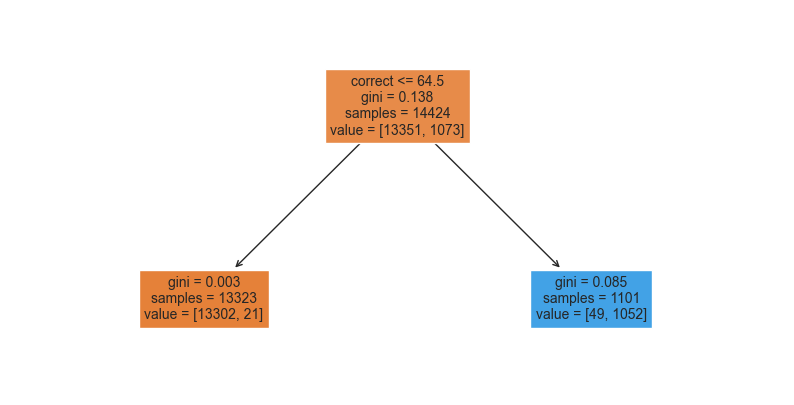

In [306]:
plt.figure(figsize=(10, 5))
plot_tree(best_clf, fontsize=10, feature_names=list(X_train), filled=True)
plt.show()

/Users/mitya/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


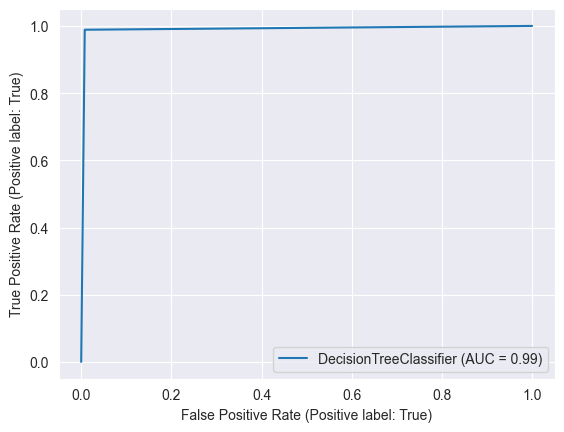

In [324]:
plot_roc_curve(best_clf, X_test, y_test)
plt.show()

/Users/mitya/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


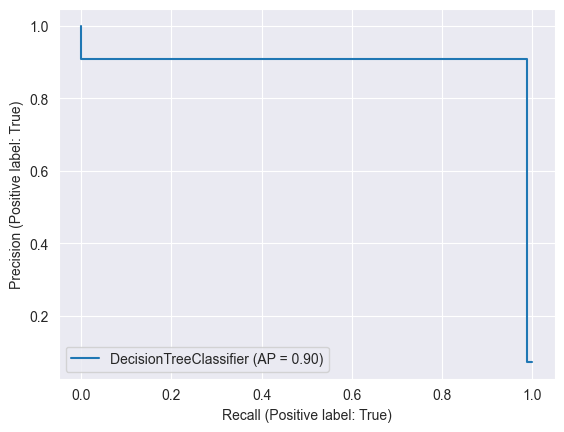

In [327]:
plot_precision_recall_curve(best_clf, X_test, y_test)
plt.show()

In [328]:
test_prob = best_clf.predict_proba(X_test)[:, 1]
test_pred = best_clf.predict(X_test)

In [330]:
print('Log loss = {:.5f}'.format(log_loss(y_test, test_prob)))
print('AUC = {:.5f}'.format(roc_auc_score(y_test, test_prob)))
print('Average Precision = {:.5f}'.format(average_precision_score(y_test, test_prob)))
print('\nUsing 0.5 as threshold:')
print('Accuracy = {:.5f}'.format(accuracy_score(y_test, test_pred)))
print('Precision = {:.5f}'.format(precision_score(y_test, test_pred)))
print('Recall = {:.5f}'.format(recall_score(y_test, test_pred)))
print('F1 score = {:.5f}'.format(f1_score(y_test, test_pred)))

print('\nClassification Report')
print(classification_report(y_test, test_pred))

Log loss = 0.03276
AUC = 0.99039
Average Precision = 0.89912

Using 0.5 as threshold:
Accuracy = 0.99189
Precision = 0.90862
Recall = 0.98864
F1 score = 0.94694

Classification Report
              precision    recall  f1-score   support

       False       1.00      0.99      1.00      4457
        True       0.91      0.99      0.95       352

    accuracy                           0.99      4809
   macro avg       0.95      0.99      0.97      4809
weighted avg       0.99      0.99      0.99      4809



Confusion Matrix


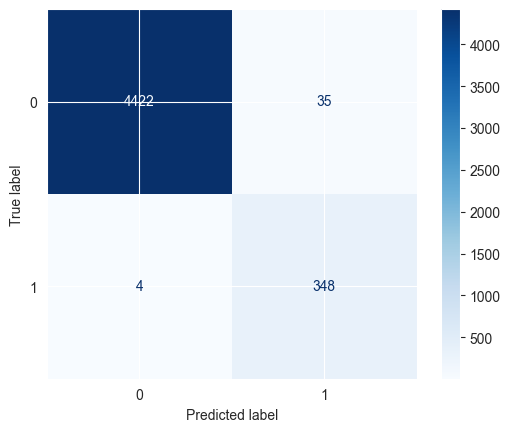

In [322]:
print('Confusion Matrix')
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

# Дополнительные задания

### Задача
Как я уже писал ранее, данные, с которыми мы работаем, обезличены, тоесть реальные id пользователей заменены случайным числом. Анонимизация пользовательских данных - очень важная тема для Data Science. С одной стороны мы хотим знать о поведении наших пользователей как можно больше, с другой стороны нам важно соблюдать приватность наших пользователей.

Поэтому данные о поведении пользователей анонимизируют не только когда речь идет об открытых данных, но и при работе с данными внутри компании. Не заметили сколько писем вам недавно пришло об изменении политики конфеденциальности, хотите узнать почему? В комментарии приложена ссылка на очень интересный доклад об этой проблеме.

А пока что вот вам хакерская задача, за каким вымышленным id скрывается Анатолий Карпов - автор курса, данные которого мы анализируем?

Введите id Анатолия Карпова, под которым он фигурирует в данных events_data_train и submissions_data_train.

In [41]:
events_train.groupby('user_id').aggregate({'action': 'count'})

,action
user_id,
1,2
2,30
3,400
5,38
7,3
...,...
26790,26
26793,3
26794,352


In [42]:
events_train.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [43]:
events_train[events_train.user_id == 20907].timestamp.min()

1434346645

In [44]:
events_train[events_train.user_id == 20907].timestamp.max()

1453480839

In [45]:
gap = events_train[events_train.user_id == 20907].timestamp.max() - events_train[events_train.user_id == 20907].timestamp.min()
gap = gap / (24 * 60 * 60)
gap

221.4605787037037

In [46]:
gap = events_train[events_train.action == 'viewed']

In [47]:
max_timestamp = gap.groupby('user_id').timestamp.apply(list).apply(max)

In [48]:
min_timestamp = gap.groupby('user_id').timestamp.apply(list).apply(min)

In [49]:
gap_t = pd.concat([min_timestamp, max_timestamp], axis=1, ignore_index=True)
gap_t.head()

,0,1
user_id,,
1,1472827464,1472827464
2,1514383364,1519226966
3,1434358476,1444581588
5,1466156809,1499859939
7,1521634660,1521634660


In [50]:
gap_t['gap'] = gap_t[1] - gap_t[0]
gap_t

,0,1,gap
user_id,,,
1,1472827464,1472827464,0
2,1514383364,1519226966,4843602
3,1434358476,1444581588,10223112
5,1466156809,1499859939,33703130
7,1521634660,1521634660,0
...,...,...,...
26790,1451484016,1517495987,66011971
26793,1510225031,1510225031,0
26794,1495287049,1512035039,16747990


In [51]:
unique_days = events_train.groupby('user_id')['day'].nunique()
unique_days

user_id
1        1
2        2
3        7
5        2
7        1
        ..
26790    4
26793    1
26794    9
26797    2
26798    1
Name: day, Length: 19234, dtype: int64

### Задача
В процессе решения одной аналитической задачи очень часто замечаешь и другие задачи, связанные с исследуемым вопросом. В свое время, работая над предсказанием оттока студентов со stepik, я многое изменил в структуре своих курсов.

Тогда я нашел довольно интересную закономерность прохождения онлайн курсов. Слушатели онлайн курсов очень негативно реагируют на невозможность решить задачу, иными словами, если студент застрял на определенном шаге, то он, с высокой вероятность, вообще бросит курс, чем просто пропустит этот шаг и продолжит обучение.

Давайте найдем такой стэп, используя данные о сабмитах. Для каждого пользователя найдите такой шаг, который он не смог решить, и после этого не пытался решать другие шаги. Затем найдите id шага,  который стал финальной точкой практического обучения на курсе для максимального числа пользователей.

То есть мы исследуем следующий сценарий: человек решает стэп, не может получить правильный ответ и больше не возвращается к практическим задачам. Что это за шаг такой, который отпугнул максимальное число пользователей?

In [94]:
submissions_train.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [123]:
submissions_train.groupby(['step_id', 'submission_status']).aggregate({'user_id': 'count'}).reset_index().query("submission_status == 'wrong' & user_id == user_id.max()")

,step_id,submission_status,user_id
9,31978,wrong,16084


In [133]:
submissions_train.mode()

,step_id,timestamp,submission_status,user_id,date,day
0,31978,1491590313,wrong,12265,2017-04-07 18:38:33,2015-07-06


In [134]:
submissions_train.sort_values(['user_id', 'timestamp'], ascending=False).drop_duplicates(['user_id'])\
        .query("submission_status == 'wrong'").groupby('step_id')\
        .count().sort_values('submission_status').tail(1)

,timestamp,submission_status,user_id,date,day
step_id,,,,,
31978,154,154,154,154,154


### Соревнование
Мы начинаем соревнование!

Задача нам уже знакома - нужно предсказать, сможет ли пользователь успешно закончить онлайн курс Анализ данных в R.

Мы будем считать, что пользователь успешно закончил курс, если он правильно решил больше 40 практических заданий.

В данных:

submission_data_test.csv
events_data_test.csv
хранится информация о решениях и действиях для 6184 студентов за первые два дня прохождения курса. Это 6184 студентов, которые проходили курс в период с мая 2018 по январь 2019. Подробное описание переменных смотри в этом шаге.

Используя данные о первых двух днях активности на курсе вам нужно предсказать, наберет ли пользователь более 40 баллов на курсе или нет.

В этих данных, вам доступны только первые дня активности студентов для того, чтобы сделать предсказание. На самом деле, используя эти данные, вы уже можете сделать прогноз. Например, если пользователь за первые два дня набрал 40 баллов, скорее всего он наберет более 40 баллов в дальнейшем. Чтобы подкрепить такие гипотезы, вы можете использовать данные, на которые мы исследовали в первых двух модулях курса, где для всех пользователей представлены все данные об их активности на курсе.


Итогом вашей работы должен стать csv файл c предсказанием для каждого студента из тестовых данных. Пример предсказания выглядит следующим образом.

Чтобы узнать точность ваших предсказаний, в качестве решения этого шага отпраьте файл с предсказаниями для каждого студента в указанном выше формате.

Убедитесь, что вы сформировали файл с предсказаними для всех 6184 студентов, для каждого студента должна быть предсказана вероятность, что он наберет более 40 баллов за курс. У вас есть 25 попыток засабмитить решения, в зачет пойдет наилучший вариант.

Результатом проверки этого задания будет значение ROC AUC score, именно по этому показателю мы и отберем победителей, успехов!

In [525]:
events_train_contest = pd.read_csv('https://stepik.org/media/attachments/course/4852/events_data_test.csv')
events_train_contest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274768 entries, 0 to 274767
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   step_id    274768 non-null  int64 
 1   timestamp  274768 non-null  int64 
 2   action     274768 non-null  object
 3   user_id    274768 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 8.4+ MB


In [526]:
submission_train_contest = pd.read_csv('https://stepik.org/media/attachments/course/4852/submission_data_test.csv')
submission_train_contest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42261 entries, 0 to 42260
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   step_id            42261 non-null  int64 
 1   timestamp          42261 non-null  int64 
 2   submission_status  42261 non-null  object
 3   user_id            42261 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.3+ MB


In [8]:
events_train_contest.head()

,step_id,timestamp,action,user_id
0,30456,1526893787,viewed,24417
1,30456,1526893797,viewed,24417
2,30456,1526893954,viewed,24417
3,30456,1526895780,viewed,24417
4,30456,1526893787,discovered,24417


In [9]:
submission_train_contest.head()

,step_id,timestamp,submission_status,user_id
0,31971,1526800961,wrong,24370
1,31971,1526800976,wrong,24370
2,31971,1526800993,wrong,24370
3,31971,1526801054,correct,24370
4,31972,1526800664,wrong,24370


In [1782]:
events_train_contest['date'] = pd.to_datetime(events_train_contest.timestamp, unit='s')

In [1783]:
events_train_contest['day'] = events_train_contest.date.dt.date

In [1784]:
events_train_contest.head()

,step_id,timestamp,action,user_id,date,day,start_day,day_number
0,30456,1526893787,viewed,24417,2018-05-21 09:09:47,2018-05-21,2015-06-15,0 days
1,30456,1526893797,viewed,24417,2018-05-21 09:09:57,2018-05-21,2015-06-15,0 days
2,30456,1526893954,viewed,24417,2018-05-21 09:12:34,2018-05-21,2015-06-15,0 days
3,30456,1526895780,viewed,24417,2018-05-21 09:43:00,2018-05-21,2015-06-15,0 days
4,30456,1526893787,discovered,24417,2018-05-21 09:09:47,2018-05-21,2015-06-15,0 days


In [1785]:
train_contest = events_train_contest.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index()

In [1786]:
train_contest.head()

action,user_id,discovered,passed,started_attempt,viewed
0,4,1,1,0,1
1,6,1,1,0,1
2,10,2,2,0,6
3,12,11,9,4,14
4,13,70,70,35,105


In [1787]:
submission_train_contest['date'] = pd.to_datetime(submission_train_contest.timestamp, unit='s')

In [1788]:
submission_train_contest['day'] = submission_train_contest.date.dt.date

In [1789]:
submission_train_contest.head()

,step_id,timestamp,submission_status,user_id,date,day,start_day,day_number
0,31971,1526800961,wrong,24370,2018-05-20 07:22:41,2018-05-20,2018-05-20,0 days
1,31971,1526800976,wrong,24370,2018-05-20 07:22:56,2018-05-20,2018-05-20,0 days
2,31971,1526800993,wrong,24370,2018-05-20 07:23:13,2018-05-20,2018-05-20,0 days
3,31971,1526801054,correct,24370,2018-05-20 07:24:14,2018-05-20,2018-05-20,0 days
4,31972,1526800664,wrong,24370,2018-05-20 07:17:44,2018-05-20,2018-05-20,0 days


In [1790]:
train_contest_submission = submission_train_contest.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0).reset_index()

In [1791]:
train_contest_submission.head()

submission_status,user_id,correct,wrong
0,12,1,0
1,13,29,36
2,15,10,30
3,21,24,103
4,35,7,35


In [1792]:
users_data_contest = train_contest.merge(train_contest_submission, on='user_id', how='outer')
users_data_contest = users_data_contest.fillna(0)

In [1793]:
users_data_contest.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong
0,4,1,1,0,1,0.0,0.0
1,6,1,1,0,1,0.0,0.0
2,10,2,2,0,6,0.0,0.0
3,12,11,9,4,14,1.0,0.0
4,13,70,70,35,105,29.0,36.0


In [539]:
users_data_contest['user_id'][users_data_contest.correct >= 40].count()

12

In [540]:
users_data_contest['user_id'].count()

6184

In [541]:
last_timestamp_contest = events_train_contest[['user_id', 'timestamp']].groupby('user_id').aggregate(
    {'timestamp': 'max'}).reset_index().rename(columns={'timestamp': 'last_timestamp'})

In [542]:
last_timestamp_contest.head()

,user_id,last_timestamp
0,4,1529331707
1,6,1546889407
2,10,1534593770
3,12,1537348641
4,13,1533162170


In [543]:
first_timestamp_contest = events_train_contest[['user_id', 'timestamp']].groupby('user_id').aggregate(
    {'timestamp': 'min'}).reset_index().rename(columns={'timestamp': 'first_timestamp'})

In [544]:
first_timestamp_contest.head()

,user_id,first_timestamp
0,4,1529331707
1,6,1546889407
2,10,1534585756
3,12,1537348474
4,13,1533034354


In [545]:
users_data_contest = users_data_contest.merge(first_timestamp_contest, on='user_id', how='outer')
users_data_contest = users_data_contest.fillna(0)

In [546]:
users_data_contest.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,first_timestamp
0,4,1,1,0,1,0.0,0.0,1529331707
1,6,1,1,0,1,0.0,0.0,1546889407
2,10,2,2,0,6,0.0,0.0,1534585756
3,12,11,9,4,14,1.0,0.0,1537348474
4,13,70,70,35,105,29.0,36.0,1533034354


In [547]:
users_data_contest = users_data_contest.merge(last_timestamp_contest, on='user_id', how='outer')
users_data_contest = users_data_contest.fillna(0)

In [548]:
users_data_contest['timestamp_gap'] = users_data_contest.last_timestamp - users_data_contest.first_timestamp

In [549]:
users_data_contest.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,first_timestamp,last_timestamp,timestamp_gap
0,4,1,1,0,1,0.0,0.0,1529331707,1529331707,0
1,6,1,1,0,1,0.0,0.0,1546889407,1546889407,0
2,10,2,2,0,6,0.0,0.0,1534585756,1534593770,8014
3,12,11,9,4,14,1.0,0.0,1537348474,1537348641,167
4,13,70,70,35,105,29.0,36.0,1533034354,1533162170,127816


In [550]:
users_data_contest['time_gap'] = round(users_data_contest['timestamp_gap'] / (24 * 60 * 60))

In [551]:
users_data_contest['avg_correct'] = users_data_contest.correct / 2

In [552]:
users_data_contest.replace([np.inf, -np.inf], 0, inplace=True)

In [553]:
users_data_contest = users_data_contest.fillna(0)

In [554]:
users_data_contest['correct_sum'] = users_data_contest.avg_correct * 30

In [555]:
users_data_contest['finish_course'] =  users_data_contest['correct_sum'] >= 40

In [556]:
users_data_contest.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,first_timestamp,last_timestamp,timestamp_gap,time_gap,avg_correct,correct_sum,finish_course
0,4,1,1,0,1,0.0,0.0,1529331707,1529331707,0,0.0,0.0,0.0,False
1,6,1,1,0,1,0.0,0.0,1546889407,1546889407,0,0.0,0.0,0.0,False
2,10,2,2,0,6,0.0,0.0,1534585756,1534593770,8014,0.0,0.0,0.0,False
3,12,11,9,4,14,1.0,0.0,1537348474,1537348641,167,0.0,0.5,15.0,False
4,13,70,70,35,105,29.0,36.0,1533034354,1533162170,127816,1.0,14.5,435.0,True


In [557]:
users_data_contest.finish_course.value_counts(normalize=True)

False    0.758571
True     0.241429
Name: finish_course, dtype: float64

In [558]:
users_data_contest.finish_course = users_data_contest.finish_course.map({True: 1, False: 0})

In [673]:
X_train = users_data_contest.drop(['first_timestamp', 'last_timestamp', 'timestamp_gap', 'time_gap', 'finish_course',  'avg_correct', 'correct_sum'], axis=1)

In [674]:
y_train = users_data_contest['finish_course']

In [561]:
users_data_contest.columns

Index(['user_id', 'discovered', 'passed', 'started_attempt', 'viewed',
       'correct', 'wrong', 'first_timestamp', 'last_timestamp',
       'timestamp_gap', 'time_gap', 'avg_correct', 'correct_sum',
       'finish_course'],
      dtype='object')

In [675]:
X_train = X_train.set_index('user_id')

In [676]:
X_train.head()

,discovered,passed,started_attempt,viewed,correct,wrong
user_id,,,,,,
4,1,1,0,1,0.0,0.0
6,1,1,0,1,0.0,0.0
10,2,2,0,6,0.0,0.0
12,11,9,4,14,1.0,0.0
13,70,70,35,105,29.0,36.0


In [766]:
test_data = train_data

In [767]:
test_data.course_completed.value_counts(normalize=True)

False    0.897676
True     0.102324
Name: course_completed, dtype: float64

In [768]:
test_data.course_completed = test_data.course_completed.map({True: 1, False: 0})

In [769]:
test_data.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,last_timestamp,is_gone,course_completed
0,1,1,0,0,1,0.0,0.0,1472827464,True,0
1,2,9,9,2,9,2.0,0.0,1519226966,True,0
2,3,15,15,4,20,29.0,23.0,1444581588,True,0
3,5,1,1,0,1,2.0,2.0,1499859939,True,0
4,7,1,1,0,1,0.0,0.0,1521634660,True,0


In [1071]:
test_data.columns

Index(['user_id', 'discovered', 'passed', 'started_attempt', 'viewed',
       'correct', 'wrong', 'last_timestamp', 'is_gone', 'course_completed',
       'avg_correct', 'correct_sum'],
      dtype='object')

In [1072]:
test_data[['user_id', 'discovered', 'passed', 'started_attempt', 'viewed',
       'correct', 'wrong', 'course_completed']]

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,course_completed
0,1,1,0,0,1,0.0,0.0,0
1,2,9,9,2,9,2.0,0.0,0
2,3,15,15,4,20,29.0,23.0,0
3,5,1,1,0,1,2.0,2.0,0
4,7,1,1,0,1,0.0,0.0,0
...,...,...,...,...,...,...,...,...
19229,26790,2,2,0,2,1.0,0.0,0
19230,26793,1,0,1,1,0.0,0.0,0
19231,26794,50,50,24,90,33.0,9.0,0
19232,26797,10,10,2,10,2.0,0.0,0


In [771]:
test_data['avg_correct'] = test_data.correct / 2

In [772]:
test_data['correct_sum'] = test_data.avg_correct * 30

In [773]:
X_test = test_data.drop(['course_completed', 'is_gone', 'last_timestamp', 'avg_correct', 'correct_sum'], axis=1)

In [774]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19233 entries, 0 to 19233
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          19233 non-null  int64  
 1   discovered       19233 non-null  int64  
 2   passed           19233 non-null  int64  
 3   started_attempt  19233 non-null  int64  
 4   viewed           19233 non-null  int64  
 5   correct          19233 non-null  float64
 6   wrong            19233 non-null  float64
dtypes: float64(2), int64(5)
memory usage: 1.2 MB


In [775]:
X_test = X_test.set_index('user_id')

In [421]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix, roc_curve, precision_recall_curve

2022-11-17 14:51:06.155523: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [723]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [724]:
X_train = scaler.transform(X_train)

In [342]:
X_train

array([[-0.56123197, -0.55068794, -0.47767589, ..., -0.293569  ,
        -0.51180643, -0.51180643],
       [-0.56123197, -0.55068794, -0.47767589, ..., -0.293569  ,
        -0.51180643, -0.51180643],
       [-0.50441417, -0.49006354, -0.47767589, ..., -0.293569  ,
        -0.51180643, -0.51180643],
       ...,
       [-0.27714297, -0.36881475, -0.25778177, ..., -0.03649867,
        -0.21144952, -0.21144952],
       [-0.27714297, -0.24756596, -0.25778177, ..., -0.293569  ,
        -0.21144952, -0.21144952],
       [-0.56123197, -0.61131233, -0.36772883, ..., -0.293569  ,
        -0.51180643, -0.51180643]])

In [778]:
scaler = StandardScaler()
scaler.fit(X_test)

StandardScaler()

In [779]:
X_test = scaler.transform(X_test)

In [780]:
y_test = test_data['course_completed']

In [806]:
n_features = X_test.shape[1]
model = Sequential()
model.add(Dense(int(round((n_features+1)/2)), input_shape=(n_features,), activation='relu'))
model.add(Dense(int(round((n_features+1)/4)), activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [807]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [808]:
model.fit(X_test, y_test, epochs=5, batch_size=10)

Epoch 1/5
1924/1924 [==============================] - 3s 1ms/step - loss: 0.3768 - accuracy: 0.9800
Epoch 2/5
1924/1924 [==============================] - 2s 1ms/step - loss: 0.1191 - accuracy: 0.9971
Epoch 3/5
1924/1924 [==============================] - 3s 1ms/step - loss: 0.0509 - accuracy: 0.9974
Epoch 4/5
1924/1924 [==============================] - 3s 1ms/step - loss: 0.0256 - accuracy: 0.9977
Epoch 5/5
1924/1924 [==============================] - 2s 1ms/step - loss: 0.0151 - accuracy: 0.9981


In [809]:
predictions_proba = model.predict(X_train)

194/194 [==============================] - 0s 961us/step


In [810]:
predictions = (model.predict(X_train) > 0.5).astype(int)

194/194 [==============================] - 0s 885us/step


In [811]:
print('Log loss = {:.5f}'.format(log_loss(y_train, predictions_proba)))
print('AUC = {:.5f}'.format(roc_auc_score(y_train, predictions_proba)))
print('Average Precision = {:.5f}'.format(average_precision_score(y_train, predictions_proba)))
print('\nUsing 0.5 as threshold:')
print('Accuracy = {:.5f}'.format(accuracy_score(y_train, predictions)))
print('Precision = {:.5f}'.format(precision_score(y_train, predictions)))
print('Recall = {:.5f}'.format(recall_score(y_train, predictions)))
print('F1 score = {:.5f}'.format(f1_score(y_train, predictions)))

print('\nClassification Report')
print(classification_report(y_train, predictions))

Log loss = nan
AUC = 0.73242
Average Precision = 0.59404

Using 0.5 as threshold:
Accuracy = 0.84994
Precision = 1.00000
Recall = 0.37843
F1 score = 0.54908

Classification Report
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      4691
           1       1.00      0.38      0.55      1493

    accuracy                           0.85      6184
   macro avg       0.92      0.69      0.73      6184
weighted avg       0.87      0.85      0.82      6184



/Users/mitya/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2465: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/Users/mitya/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2465: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


In [798]:
print('Log loss = {:.5f}'.format(log_loss(y_test, predictions_proba)))
print('AUC = {:.5f}'.format(roc_auc_score(y_test, predictions_proba)))
print('Average Precision = {:.5f}'.format(average_precision_score(y_test, predictions_proba)))
print('\nUsing 0.5 as threshold:')
print('Accuracy = {:.5f}'.format(accuracy_score(y_test, predictions)))
print('Precision = {:.5f}'.format(precision_score(y_test, predictions)))
print('Recall = {:.5f}'.format(recall_score(y_test, predictions)))
print('F1 score = {:.5f}'.format(f1_score(y_test, predictions)))

print('\nClassification Report')
print(classification_report(y_test, predictions))

Log loss = nan
AUC = 1.00000
Average Precision = 0.99997

Using 0.5 as threshold:
Accuracy = 0.99927
Precision = 0.99343
Recall = 0.99949
F1 score = 0.99645

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17265
           1       0.99      1.00      1.00      1968

    accuracy                           1.00     19233
   macro avg       1.00      1.00      1.00     19233
weighted avg       1.00      1.00      1.00     19233



/Users/mitya/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2465: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/Users/mitya/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2465: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


In [812]:
fpr, tpr, _ = roc_curve(y_train, predictions_proba)

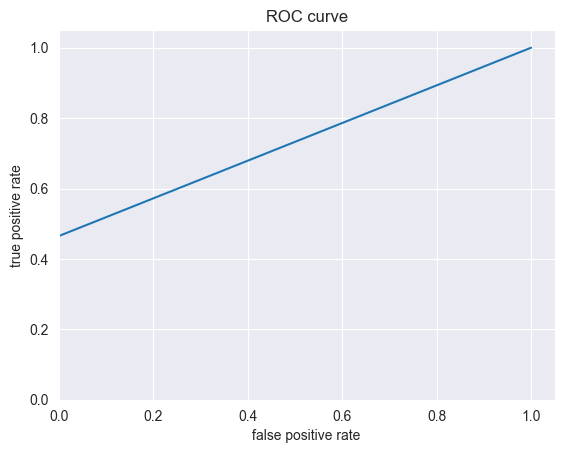

In [813]:
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()

In [814]:
pr, rc, _ = precision_recall_curve(y_train, predictions_proba)

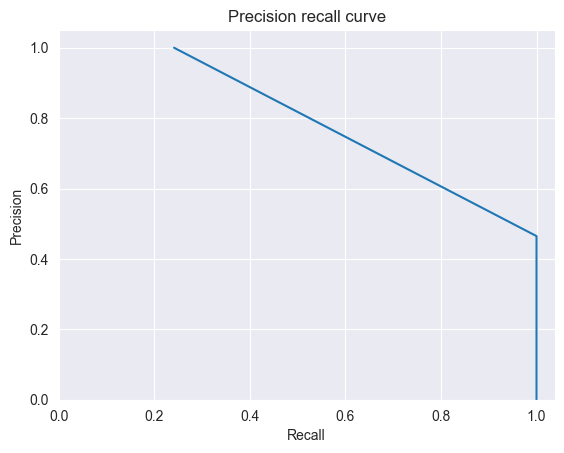

In [815]:
plt.plot(pr, rc)
plt.title('Precision recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0,)
plt.ylim(0,)
plt.show()

Confusion Matrix


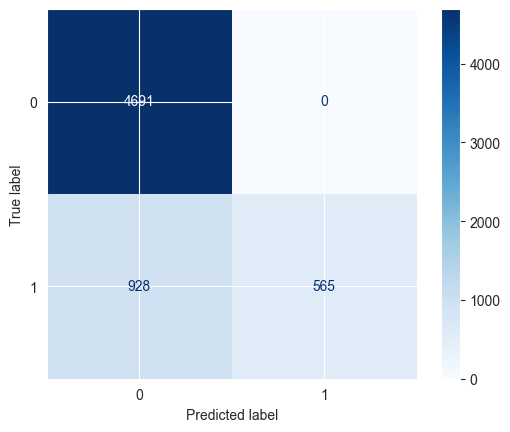

In [816]:
print('Confusion Matrix')
conf_matrix = confusion_matrix(y_train, predictions)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

Confusion Matrix


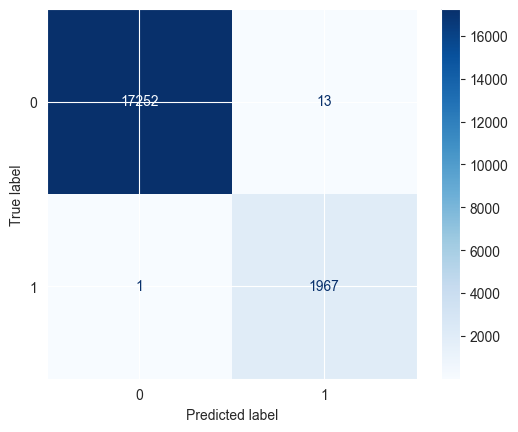

In [804]:
print('Confusion Matrix')
conf_matrix = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

In [462]:
predictions_proba_train = model.predict(X_train)

194/194 [==============================] - 0s 1ms/step


In [463]:
predictions_train = (model.predict(X_train) > 0.5).astype(int)

194/194 [==============================] - 0s 1ms/step


In [464]:
print('Log loss = {:.5f}'.format(log_loss(y_train, predictions_proba_train)))
print('AUC = {:.5f}'.format(roc_auc_score(y_train, predictions_proba_train)))
print('Average Precision = {:.5f}'.format(average_precision_score(y_train, predictions_proba_train)))
print('\nUsing 0.5 as threshold:')
print('Accuracy = {:.5f}'.format(accuracy_score(y_train, predictions_train)))
print('Precision = {:.5f}'.format(precision_score(y_train, predictions_train)))
print('Recall = {:.5f}'.format(recall_score(y_train, predictions_train)))
print('F1 score = {:.5f}'.format(f1_score(y_train, predictions_train)))

print('\nClassification Report')
print(classification_report(y_train, predictions_train))

Log loss = nan
AUC = 1.00000
Average Precision = 1.00000

Using 0.5 as threshold:
Accuracy = 1.00000
Precision = 1.00000
Recall = 1.00000
F1 score = 1.00000

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4691
           1       1.00      1.00      1.00      1493

    accuracy                           1.00      6184
   macro avg       1.00      1.00      1.00      6184
weighted avg       1.00      1.00      1.00      6184



/Users/mitya/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2465: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/Users/mitya/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2465: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


In [817]:
export_data = pd.concat([pd.Series(users_data_contest.user_id), pd.DataFrame(predictions_proba)], axis=1)

In [818]:
export_data.columns = ['user_id', 'is_gone']

In [819]:
export_data.head()

,user_id,is_gone
0,4,0.006542
1,6,0.006542
2,10,0.006542
3,12,0.006542
4,13,1.000000


In [820]:
export_data.to_csv('/Users/mitya/out.csv', index=False)

=================================

### Попытка # 2

In [110]:
events_test_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip')

In [111]:
submissions_test_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip')

In [344]:
events_test_contest = events_test_data

In [345]:
submissions_test_contest = submissions_test_data

In [346]:
submissions_test_contest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509104 entries, 0 to 509103
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   step_id            509104 non-null  int64         
 1   timestamp          509104 non-null  int64         
 2   submission_status  509104 non-null  object        
 3   user_id            509104 non-null  int64         
 4   date               509104 non-null  datetime64[ns]
 5   day                509104 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 23.3+ MB


In [347]:
events_test_contest.user_id.nunique()

19234

In [348]:
submissions_test_contest.user_id.nunique()

9940

In [349]:
events_test_contest['date'] = pd.to_datetime(events_test_contest.timestamp, unit='s')

In [350]:
events_test_contest['day'] = events_test_contest.date.dt.date

In [351]:
events_test_contest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3480703 entries, 0 to 3480702
Data columns (total 6 columns):
 #   Column     Dtype         
---  ------     -----         
 0   step_id    int64         
 1   timestamp  int64         
 2   action     object        
 3   user_id    int64         
 4   date       datetime64[ns]
 5   day        object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 159.3+ MB


In [352]:
events_test_contest = events_test_contest.drop_duplicates(subset=['user_id', 'step_id', 'action'])

In [353]:
submissions_test_contest['date'] = pd.to_datetime(submissions_test_contest.timestamp, unit='s')

In [354]:
submissions_test_contest['day'] = submissions_test_contest.date.dt.date

In [355]:
# submissions_test_contest = submissions_test_contest.drop_duplicates(subset=['user_id', 'step_id', 'submission_status'], keep='first')
submissions_test_contest = submissions_test_contest[~(submissions_test_contest.duplicated(['user_id', 'step_id', 'submission_status']) & submissions_test_contest.submission_status.eq('correct'))]

In [356]:
first_timestamp = events_test_contest[['user_id', 'timestamp']].groupby('user_id').aggregate({'timestamp': 'min'}).reset_index().rename(columns={'timestamp': 'first_timestamp'})

In [357]:
first_timestamp.head()

,user_id,first_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [358]:
events_test_contest = events_test_contest.merge(first_timestamp, on='user_id', how='outer').fillna(0)

In [359]:
events_test_contest.first_timestamp.info()

<class 'pandas.core.series.Series'>
Int64Index: 2266452 entries, 0 to 2266451
Series name: first_timestamp
Non-Null Count    Dtype
--------------    -----
2266452 non-null  int64
dtypes: int64(1)
memory usage: 34.6 MB


In [360]:
submissions_test_contest = submissions_test_contest.merge(first_timestamp, on='user_id', how='left').fillna(0)

In [361]:
timestamp_threshold = 2 * 24 * 60 * 60

In [362]:
events_test_contest['first_two_days'] = events_test_contest.timestamp <= events_test_contest.first_timestamp + timestamp_threshold

In [363]:
events_test_contest = events_test_contest[events_test_contest.first_two_days == True]

In [364]:
events_test_contest.head()

,step_id,timestamp,action,user_id,date,day,first_timestamp,first_two_days
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,True
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,True
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848,True
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848,True
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848,True


In [365]:
submissions_test_contest['first_two_days'] = submissions_test_contest.timestamp <= submissions_test_contest.first_timestamp + timestamp_threshold

In [366]:
submissions_test_contest.head()

,step_id,timestamp,submission_status,user_id,date,day,first_timestamp,first_two_days
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15,1434345977,True
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15,1434345977,True
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11,1434345977,False
3,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15,1434345977,True
4,31976,1434348188,correct,15853,2015-06-15 06:03:08,2015-06-15,1434345977,True


In [367]:
submissions_test_contest.first_two_days.nunique()

2

In [368]:
submissions_test_contest = submissions_test_contest[submissions_test_contest.first_two_days == True]

In [369]:
start_day_submissions = submissions_test_contest[['user_id', 'day']].groupby('user_id').aggregate({'day': 'min'}).reset_index().rename(columns={'day': 'start_day'})

In [370]:
submissions_test_contest = submissions_test_contest.merge(start_day_submissions, on='user_id', how='outer').fillna(0)

In [371]:
submissions_test_contest['day_number'] = submissions_test_contest.day - submissions_test_contest.start_day

In [372]:
# submissions_test_contest = submissions_test_contest[(submissions_train.day_number == '0 days') | (submissions_test_contest.day_number == '1 days')]

In [373]:
submissions_pivot_table = submissions_test_contest.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0).reset_index()

In [374]:
submissions_pivot_table['course_complete'] = submissions_pivot_table.correct > 40

In [375]:
submissions_pivot_table.groupby('course_complete').aggregate({'user_id': 'count'})

submission_status,user_id
course_complete,
False,8772
True,43


In [376]:
# submissions_pivot_table.groupby('course_complete').aggregate({'user_id': 'count'})

In [377]:
#  submissions_first_two_days = submissions_test_contest[(submissions_test_contest.day_number == '0 days') | (submissions_test_contest.day_number == '1 days')]

submissions_first_two_days = submissions_test_contest[submissions_test_contest.first_two_days == True]

In [378]:
submissions_first_two_days.first_two_days.nunique()

1

In [379]:
submissions_first_two_days.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114529 entries, 0 to 114528
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype          
---  ------             --------------   -----          
 0   step_id            114529 non-null  int64          
 1   timestamp          114529 non-null  int64          
 2   submission_status  114529 non-null  object         
 3   user_id            114529 non-null  int64          
 4   date               114529 non-null  datetime64[ns] 
 5   day                114529 non-null  object         
 6   first_timestamp    114529 non-null  int64          
 7   first_two_days     114529 non-null  bool           
 8   start_day          114529 non-null  object         
 9   day_number         114529 non-null  timedelta64[ns]
dtypes: bool(1), datetime64[ns](1), int64(4), object(3), timedelta64[ns](1)
memory usage: 8.8+ MB


In [380]:
submissions_first_two_days.user_id.nunique()

8815

In [381]:
submissions_first_two_days_pivot_table = submissions_first_two_days.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0).reset_index()

In [382]:
submissions_first_two_days_pivot_table.correct.sum()

59904

In [383]:
submissions_pivot_table = submissions_pivot_table.drop(['correct', 'wrong'], axis=1)

In [384]:
# В итоговую таблицу попадают пользователи успешно прошедшие курс, которые проходили практические задания первые два дня
submissions_pivot_table = submissions_pivot_table[['user_id', 'course_complete']].merge(submissions_first_two_days_pivot_table, on='user_id', how='outer').fillna(0)

# submissions_pivot_table = submissions_first_two_days_pivot_table

#

In [385]:
submissions_pivot_table.head()

submission_status,user_id,course_complete,correct,wrong
0,2,False,2,0
1,3,False,4,4
2,8,False,9,21
3,14,False,0,1
4,16,False,18,23


In [386]:
submissions_pivot_table.nunique()

submission_status
user_id            8815
course_complete       2
correct              66
wrong               108
dtype: int64

In [387]:
submissions_pivot_table.groupby('course_complete').aggregate({'user_id': 'count'})

submission_status,user_id
course_complete,
False,8772
True,43


In [388]:
submissions_pivot_table.user_id.nunique()

8815

In [389]:
submissions_first_day = submissions_test_contest[submissions_test_contest.timestamp <= submissions_test_contest.first_timestamp + 24 * 60 * 60].pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0).reset_index().rename(columns={'correct': 'first_day_correct', 'wrong': 'first_day_wrong'})

In [390]:
submissions_first_day.head()

submission_status,user_id,first_day_correct,first_day_wrong
0,2,2,0
1,3,4,4
2,8,9,21
3,14,0,1
4,16,18,23


In [391]:
submissions_second_day = submissions_test_contest[(submissions_test_contest.timestamp > submissions_test_contest.first_timestamp + 24 * 60 * 60) & (submissions_test_contest.timestamp <= submissions_test_contest.first_timestamp + 2 * 24 * 60 * 60)].pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0).reset_index().rename(columns={'correct': 'second_day_correct', 'wrong': 'second_day_wrong'})

In [392]:
submissions_second_day.head()

submission_status,user_id,second_day_correct,second_day_wrong
0,22,2,0
1,57,1,4
2,75,2,0
3,89,6,3
4,91,4,8


In [393]:
submissions_second_day.second_day_correct.sum() + submissions_first_day.first_day_correct.sum()

59904

In [394]:
submissions_pivot_table.correct.sum()

59904

In [395]:
retention = submissions_first_day.merge(submissions_second_day, on='user_id', how='outer').fillna(0)

In [396]:
retention = retention.merge(submissions_pivot_table, on='user_id', how='outer').fillna(0)

In [397]:
retention.columns

Index(['user_id', 'first_day_correct', 'first_day_wrong', 'second_day_correct',
       'second_day_wrong', 'course_complete', 'correct', 'wrong'],
      dtype='object', name='submission_status')

In [398]:
retention.user_id.nunique()

8815

In [399]:
# retention.groupby('course_complete').aggregate({'user_id': 'count'})

In [400]:
# start_day_events = events_test_contest[['user_id', 'day']].groupby('user_id').aggregate({'day': 'min'}).reset_index().rename(columns={'day': 'start_day'})

In [401]:
# events_test_contest = events_test_contest.merge(start_day_events, on='user_id', how='outer').fillna(0)

In [402]:
retention_events_pivot = events_test_contest.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index()

In [403]:
# retention_events_pivot['course_complete'] = retention_events_pivot.passed > 170

In [404]:
# retention_events_pivot = retention_events_pivot.drop(['discovered', 'passed', 'started_attempt', 'viewed'], axis=1)

In [405]:
# retention_events_pivot.groupby('course_complete').agg({'user_id': 'count'})

In [406]:
# events_test_contest['day_number'] = events_test_contest.day - events_test_contest.start_day

In [407]:
events_test_contest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 763658 entries, 0 to 2266451
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   step_id          763658 non-null  int64         
 1   timestamp        763658 non-null  int64         
 2   action           763658 non-null  object        
 3   user_id          763658 non-null  int64         
 4   date             763658 non-null  datetime64[ns]
 5   day              763658 non-null  object        
 6   first_timestamp  763658 non-null  int64         
 7   first_two_days   763658 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(4), object(2)
memory usage: 47.3+ MB


In [408]:
events_first_two_days = events_test_contest[events_test_contest.first_two_days == True]

In [409]:
events_first_two_days.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 763658 entries, 0 to 2266451
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   step_id          763658 non-null  int64         
 1   timestamp        763658 non-null  int64         
 2   action           763658 non-null  object        
 3   user_id          763658 non-null  int64         
 4   date             763658 non-null  datetime64[ns]
 5   day              763658 non-null  object        
 6   first_timestamp  763658 non-null  int64         
 7   first_two_days   763658 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(4), object(2)
memory usage: 47.3+ MB


In [410]:
events_first_two_days_pivot = events_first_two_days.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index()

In [411]:
events_first_two_days_pivot.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,9
2,3,15,15,4,15
3,5,1,1,0,1
4,7,1,1,0,1


In [412]:
events_first_day = events_first_two_days[events_first_two_days.timestamp <= events_first_two_days.first_timestamp + 24 * 60* 60].pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index().rename(columns={'viewed': 'first_day_viewed', 'passed': 'first_day_passed', 'discovered': 'first_day_discovered', 'started_attempt':'first_day_started_attempt'})

In [413]:
events_second_day = events_first_two_days[(events_first_two_days.timestamp > events_first_two_days.first_timestamp + 24 * 60* 60)&(events_first_two_days.timestamp <= events_first_two_days.first_timestamp + 2 * 24 * 60* 60)].pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index().rename(columns={'viewed': 'second_day_viewed', 'passed': 'second_day_passed', 'discovered': 'second_day_discovered', 'started_attempt':'second_day_started_attempt'})

In [414]:
events_first_two_days_pivot[events_first_two_days_pivot.user_id == 11561]

action,user_id,discovered,passed,started_attempt,viewed
8323,11561,108,67,41,108


In [415]:
events_first_day[events_first_day.user_id == 11561]

action,user_id,first_day_discovered,first_day_passed,first_day_started_attempt,first_day_viewed
8323,11561,103,63,40,103


In [416]:
events_second_day[events_second_day.user_id == 11561]

action,user_id,second_day_discovered,second_day_passed,second_day_started_attempt,second_day_viewed
1176,11561,5,4,1,5


In [417]:
events_first_day.first_day_passed.sum() + events_second_day.second_day_passed.sum()

219403

In [418]:
events_first_two_days_pivot.passed.sum()

219403

In [419]:
# retention_events_pivot = retention_events_pivot.merge(events_first_two_days_pivot, on='user_id', how='outer').fillna(0)

In [420]:
retention_events_pivot = retention_events_pivot.merge(events_first_day, on='user_id', how='outer').fillna(0)

In [421]:
retention_events_pivot.head()

action,user_id,discovered,passed,started_attempt,viewed,first_day_discovered,first_day_passed,first_day_started_attempt,first_day_viewed
0,1,1,0,0,1,1,0,0,1
1,2,9,9,2,9,9,9,2,9
2,3,15,15,4,15,15,15,4,15
3,5,1,1,0,1,1,1,0,1
4,7,1,1,0,1,1,1,0,1


In [422]:
retention_events_pivot = retention_events_pivot.merge(events_second_day, on='user_id', how='outer').fillna(0)

In [423]:
retention_events_pivot[['correct', 'wrong', 'discovered', 'passed', 'started_attempt', 'viewed',
       'day', 'course_complete']]

KeyError: "['correct', 'wrong', 'day', 'course_complete'] not in index"

In [424]:
retention_events_pivot.groupby('course_complete').agg({'user_id': 'count'})

KeyError: 'course_complete'

In [425]:
events_test_contest.user_id.nunique()

19234

In [426]:
events_first_two_days.user_id.nunique()

19234

In [427]:
retention_events_pivot.user_id.nunique()

19234

In [428]:
# retention_events_pivot.groupby('course_complete').agg({'user_id': 'count'})

In [429]:
retention = retention.merge(retention_events_pivot, on='user_id', how='outer').fillna(0)

In [430]:
retention[['correct', 'wrong', 'discovered', 'passed', 'started_attempt', 'viewed',
       'day', 'course_complete']]

KeyError: "['day'] not in index"

In [2026]:
submissions_pivot_table.groupby('course_complete').aggregate({'user_id': 'count'})

submission_status,user_id
course_complete,
False,7972
True,1968


In [431]:
retention.groupby('course_complete').agg({'user_id': 'count'})

,user_id
course_complete,
False,19191
True,43


In [2028]:
retention.columns

Index(['user_id', 'first_day_correct', 'first_day_wrong', 'second_day_correct',
       'second_day_wrong', 'correct', 'wrong', 'course_complete', 'discovered',
       'passed', 'started_attempt', 'viewed', 'first_day_discovered',
       'first_day_passed', 'first_day_started_attempt', 'first_day_viewed',
       'second_day_discovered', 'second_day_passed',
       'second_day_started_attempt', 'second_day_viewed'],
      dtype='object')

In [2029]:
retention['correct_ratio'] = (retention.second_day_correct / retention.first_day_correct).fillna(0)

In [2030]:
retention['wrong_ratio'] = (retention.second_day_wrong / retention.first_day_wrong).fillna(0)

In [2031]:
retention['discovered_ratio'] = (retention.second_day_discovered / retention.first_day_discovered).fillna(0)

In [2032]:
retention['passed_ratio'] = (retention.second_day_passed / retention.first_day_passed).fillna(0)

In [2033]:
retention['started_attempt_ratio'] = (retention.second_day_started_attempt / retention.first_day_started_attempt).fillna(0)

In [2034]:
retention['viewed_ratio'] = (retention.second_day_viewed / retention.first_day_viewed).fillna(0)

In [2035]:
retention.replace([np.inf, -np.inf], 0, inplace=True)

In [2036]:
retention_clear = retention.drop(['first_day_correct', 'first_day_wrong', 'second_day_correct',
       'second_day_wrong', 'first_day_discovered',
       'first_day_passed', 'first_day_started_attempt', 'first_day_viewed',
       'second_day_discovered', 'second_day_passed',
       'second_day_started_attempt', 'second_day_viewed'], axis=1)

In [2037]:
retention.head()

,user_id,first_day_correct,first_day_wrong,second_day_correct,second_day_wrong,correct,wrong,course_complete,discovered,passed,...,second_day_discovered,second_day_passed,second_day_started_attempt,second_day_viewed,correct_ratio,wrong_ratio,discovered_ratio,passed_ratio,started_attempt_ratio,viewed_ratio
0,2,2.0,0.0,0.0,0.0,2.0,0.0,False,9,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,4.0,4.0,0.0,0.0,29.0,23.0,False,91,87,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8,9.0,21.0,0.0,0.0,9.0,21.0,False,109,84,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,14,0.0,1.0,0.0,0.0,0.0,1.0,False,4,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,16,18.0,23.0,0.0,0.0,77.0,106.0,True,196,196,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2038]:
retention_clear.head()

,user_id,correct,wrong,course_complete,discovered,passed,started_attempt,viewed,correct_ratio,wrong_ratio,discovered_ratio,passed_ratio,started_attempt_ratio,viewed_ratio
0,2,2.0,0.0,False,9,9,2,10,0.0,0.0,0.0,0.0,0.0,0.0
1,3,29.0,23.0,False,91,87,30,192,0.0,0.0,0.0,0.0,0.0,0.0
2,8,9.0,21.0,False,109,84,37,156,0.0,0.0,0.0,0.0,0.0,0.0
3,14,0.0,1.0,False,4,3,1,9,0.0,0.0,0.0,0.0,0.0,0.0
4,16,77.0,106.0,True,196,196,108,651,0.0,0.0,0.0,0.0,0.0,0.0


In [2039]:
retention.columns

Index(['user_id', 'first_day_correct', 'first_day_wrong', 'second_day_correct',
       'second_day_wrong', 'correct', 'wrong', 'course_complete', 'discovered',
       'passed', 'started_attempt', 'viewed', 'first_day_discovered',
       'first_day_passed', 'first_day_started_attempt', 'first_day_viewed',
       'second_day_discovered', 'second_day_passed',
       'second_day_started_attempt', 'second_day_viewed', 'correct_ratio',
       'wrong_ratio', 'discovered_ratio', 'passed_ratio',
       'started_attempt_ratio', 'viewed_ratio'],
      dtype='object')

In [2040]:
retention_clear.columns

Index(['user_id', 'correct', 'wrong', 'course_complete', 'discovered',
       'passed', 'started_attempt', 'viewed', 'correct_ratio', 'wrong_ratio',
       'discovered_ratio', 'passed_ratio', 'started_attempt_ratio',
       'viewed_ratio'],
      dtype='object')

In [2041]:
retention.groupby('course_complete').aggregate({'user_id':'count'})

,user_id
course_complete,
False,17266
True,1968


In [1352]:
# retention[(retention.passed >= 8) | (retention.correct > 1)].count()

In [1353]:
# retention[(retention.passed < 8) | (retention.correct <= 1)].count()

<AxesSubplot:>

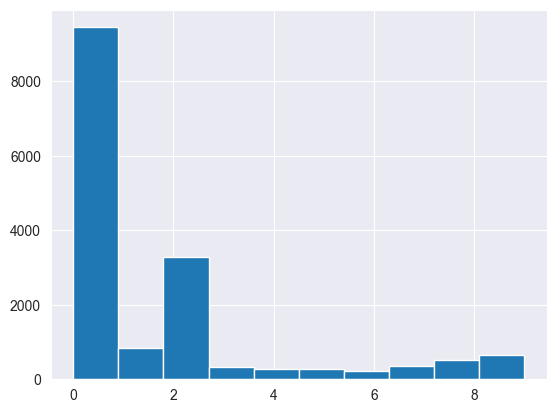

In [359]:
# retention[(retention.course_complete == False) & (retention.correct < 10)].correct.hist()

### Test Data Preparation

In [2118]:
events_train_contest = pd.read_csv('https://stepik.org/media/attachments/course/4852/events_data_test.csv')

In [2119]:
submission_train_contest = pd.read_csv('https://stepik.org/media/attachments/course/4852/submission_data_test.csv')

In [2120]:
events_train_contest['date'] = pd.to_datetime(events_train_contest.timestamp, unit='s')

In [2121]:
events_train_contest['day'] = events_train.date.dt.date

In [2122]:
submission_train_contest['date'] = pd.to_datetime(submission_train_contest.timestamp, unit='s')

In [2123]:
submission_train_contest['day'] = submission_train_contest.date.dt.date

In [2124]:
start_day_events = events_train_contest[['user_id', 'day']].groupby('user_id').aggregate({'day': 'min'}).reset_index().rename(columns={'day': 'start_day'})

In [2125]:
start_day_submissions = submission_train_contest[['user_id', 'day']].groupby('user_id').aggregate({'day': 'min'}).reset_index().rename(columns={'day': 'start_day'})

In [2126]:
events_train_contest = events_train_contest.merge(start_day_events, on='user_id', how='outer').fillna(0)

In [2127]:
events_train_contest['day_number'] = events_train_contest.day - events_train_contest.start_day

In [2128]:
submission_train_contest = submission_train_contest.merge(start_day_submissions, on='user_id', how='outer').fillna(0)

In [2129]:
submission_train_contest['day_number'] = submission_train_contest.day - submission_train_contest.start_day

In [2131]:
first_timestamp_events_train = events_train_contest.groupby('user_id').aggregate({'timestamp': 'min'}).reset_index().rename(columns={'timestamp': 'first_timestamp'})

In [2132]:
first_timestamp_events_train.head()

,user_id,first_timestamp
0,4,1529331707
1,6,1546889407
2,10,1534585756
3,12,1537348474
4,13,1533034354


In [2133]:
events_train_contest = events_train_contest.merge(first_timestamp_events_train, on='user_id', how='outer').fillna(0)

TypeError: value should be a 'Timedelta', 'NaT', or array of those. Got 'int' instead.

In [2076]:
events_first_day_sm = events_train_contest[events_train_contest.day_number == '0 days'].pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index().rename(columns={'viewed': 'first_day_viewed', 'passed': 'first_day_passed', 'discovered': 'first_day_discovered', 'started_attempt':'first_day_started_attempt'})

In [2077]:
events_second_day_sm = events_train_contest[events_train_contest.day_number == '1 days'].pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index().rename(columns={'viewed': 'second_day_viewed', 'passed': 'second_day_passed', 'discovered': 'second_day_discovered', 'started_attempt':'second_day_started_attempt'})

In [2078]:
events_pivot_sm = events_train_contest.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index()

In [2079]:
events_pivot_sm = events_pivot_sm.merge(events_first_day_sm, on='user_id', how='outer').fillna(0)

In [2080]:
events_pivot_sm = events_pivot_sm.merge(events_second_day_sm, on='user_id', how='outer').fillna(0)

In [2081]:
submission_first_day_sm = submission_train_contest[submission_train_contest.day_number == '0 days'].pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0).reset_index().rename(columns={'correct': 'first_day_correct', 'wrong': 'first_day_wrong'})

In [2082]:
submissions_second_day_sm = submission_train_contest[submission_train_contest.day_number == '1 days'].pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0).reset_index().rename(columns={'correct': 'second_day_correct', 'wrong': 'second_day_wrong'})

In [2083]:
submissions_pivot_sm = submission_train_contest.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0).reset_index()

In [2084]:
submissions_pivot_sm = submissions_pivot_sm.merge(submission_first_day_sm, on='user_id', how='outer').fillna(0)

In [2085]:
submissions_pivot_sm = submissions_pivot_sm.merge(submissions_second_day_sm, on='user_id', how='outer').fillna(0)

In [2086]:
retention_sm = events_pivot_sm.merge(submissions_pivot_sm, on='user_id', how='outer').fillna(0)

In [2087]:
retention_sm['correct_ratio'] = (retention_sm.second_day_correct / retention_sm.first_day_correct).fillna(0)

In [2088]:
retention_sm['wrong_ratio'] = (retention_sm.second_day_wrong / retention_sm.first_day_wrong).fillna(0)

In [2089]:
retention_sm['discovered_ratio'] = (retention_sm.second_day_discovered / retention_sm.first_day_discovered).fillna(0)

In [2090]:
retention_sm['passed_ratio'] = (retention_sm.second_day_passed / retention_sm.first_day_passed).fillna(0)

In [2091]:
retention_sm['started_attempt_ratio'] = (retention_sm.second_day_started_attempt / retention_sm.first_day_started_attempt).fillna(0)

In [2092]:
retention_sm['viewed_ratio'] = (retention_sm.second_day_viewed / retention_sm.first_day_viewed).fillna(0)

In [2093]:
retention_sm.replace([np.inf, -np.inf], 0, inplace=True)

In [2094]:
retention_clear_sm = retention_sm.drop(['first_day_correct', 'first_day_wrong', 'second_day_correct',
       'second_day_wrong', 'first_day_discovered',
       'first_day_passed', 'first_day_started_attempt', 'first_day_viewed',
       'second_day_discovered', 'second_day_passed',
       'second_day_started_attempt', 'second_day_viewed'], axis=1)

In [2095]:
retention_clear_sm.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,correct_ratio,wrong_ratio,discovered_ratio,passed_ratio,started_attempt_ratio,viewed_ratio
0,4,1,1,0,1,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0
1,6,1,1,0,1,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0
2,10,2,2,0,6,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0
3,12,11,9,4,14,1.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0
4,13,70,70,35,105,29.0,36.0,0.8125,0.384615,0.0,0.0,0.0,0.0


In [2097]:
retention_sm.columns

Index(['user_id', 'discovered', 'passed', 'started_attempt', 'viewed',
       'first_day_discovered', 'first_day_passed', 'first_day_started_attempt',
       'first_day_viewed', 'second_day_discovered', 'second_day_passed',
       'second_day_started_attempt', 'second_day_viewed', 'correct', 'wrong',
       'first_day_correct', 'first_day_wrong', 'second_day_correct',
       'second_day_wrong', 'correct_ratio', 'wrong_ratio', 'discovered_ratio',
       'passed_ratio', 'started_attempt_ratio', 'viewed_ratio'],
      dtype='object')

In [2101]:
X_test = retention_sm.drop(['first_day_correct', 'first_day_wrong', 'second_day_correct',
       'second_day_wrong', 'correct_ratio', 'wrong_ratio', 'discovered_ratio',
       'passed_ratio', 'started_attempt_ratio', 'viewed_ratio'], axis=1)

In [1354]:
retention_clear.groupby('course_complete').agg({'user_id': 'count'})

,user_id
course_complete,
False,17491
True,1743


In [1069]:
retention_clear[['user_id', 'correct', 'wrong', 'course_complete', 'discovered',
       'passed', 'started_attempt', 'viewed']]

,user_id,correct,wrong,course_complete,discovered,passed,started_attempt,viewed
0,2,2.0,0.0,False,9,9,2,9
1,3,4.0,4.0,True,15,15,4,20
2,5,2.0,2.0,False,1,1,0,1
3,8,9.0,21.0,True,109,84,37,154
4,14,0.0,1.0,False,4,3,1,9
...,...,...,...,...,...,...,...,...
19229,26773,0.0,0.0,False,1,1,0,1
19230,26774,0.0,0.0,False,1,1,0,1
19231,26788,0.0,0.0,False,1,1,0,1
19232,26789,0.0,0.0,False,2,2,0,2


In [1041]:
retention.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19234 entries, 0 to 19233
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_id                     19234 non-null  int64  
 1   first_day_correct           19234 non-null  float64
 2   first_day_wrong             19234 non-null  float64
 3   second_day_correct          19234 non-null  float64
 4   second_day_wrong            19234 non-null  float64
 5   correct                     19234 non-null  float64
 6   wrong                       19234 non-null  float64
 7   course_complete             19234 non-null  bool   
 8   discovered                  19234 non-null  int64  
 9   passed                      19234 non-null  int64  
 10  started_attempt             19234 non-null  int64  
 11  viewed                      19234 non-null  int64  
 12  first_day_discovered        19234 non-null  int64  
 13  first_day_passed            192

In [2042]:
X_train = retention.drop(['course_complete', 'correct_ratio', 'wrong_ratio', 'discovered_ratio', 'passed_ratio', 'started_attempt_ratio', 'viewed_ratio'], axis=1)
# X_train = retention[['correct', 'user_id', 'passed']]
# 'discovered', 'correct_ratio', 'wrong_ratio', 'discovered_ratio', 'passed_ratio', 'started_attempt_ratio', 'viewed_ratio', 'correct', 'wrong', 'passed', 'started_attempt', 'viewed'

In [2044]:
X_train.head()

,user_id,first_day_correct,first_day_wrong,second_day_correct,second_day_wrong,correct,wrong,discovered,passed,started_attempt,viewed,first_day_discovered,first_day_passed,first_day_started_attempt,first_day_viewed,second_day_discovered,second_day_passed,second_day_started_attempt,second_day_viewed
0,2,2.0,0.0,0.0,0.0,2.0,0.0,9,9,2,10,9,9,2,9,0.0,0.0,0.0,0.0
1,3,4.0,4.0,0.0,0.0,29.0,23.0,91,87,30,192,15,15,4,20,0.0,0.0,0.0,0.0
2,8,9.0,21.0,0.0,0.0,9.0,21.0,109,84,37,156,109,84,37,154,0.0,0.0,0.0,0.0
3,14,0.0,1.0,0.0,0.0,0.0,1.0,4,3,1,9,4,3,1,9,0.0,0.0,0.0,0.0
4,16,18.0,23.0,0.0,0.0,77.0,106.0,196,196,108,651,50,49,21,117,0.0,0.0,0.0,0.0


In [2045]:
X_train = X_train.set_index('user_id')

In [2046]:
y_train = retention['course_complete']

In [2047]:
y_train = y_train.map({True: 1, False: 0})

In [1048]:
X_test = retention_clear_sm

In [2102]:
X_test = X_test.set_index('user_id')

In [2051]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [2052]:
X_train = scaler.transform(X_train)

In [2050]:
X_train

,first_day_correct,first_day_wrong,second_day_correct,second_day_wrong,correct,wrong,discovered,passed,started_attempt,viewed,first_day_discovered,first_day_passed,first_day_started_attempt,first_day_viewed,second_day_discovered,second_day_passed,second_day_started_attempt,second_day_viewed
user_id,,,,,,,,,,,,,,,,,,
2,2.0,0.0,0.0,0.0,2.0,0.0,9,9,2,10,9,9,2,9,0.0,0.0,0.0,0.0
3,4.0,4.0,0.0,0.0,29.0,23.0,91,87,30,192,15,15,4,20,0.0,0.0,0.0,0.0
8,9.0,21.0,0.0,0.0,9.0,21.0,109,84,37,156,109,84,37,154,0.0,0.0,0.0,0.0
14,0.0,1.0,0.0,0.0,0.0,1.0,4,3,1,9,4,3,1,9,0.0,0.0,0.0,0.0
16,18.0,23.0,0.0,0.0,77.0,106.0,196,196,108,651,50,49,21,117,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26773,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0,1,1,1,0,1,0.0,0.0,0.0,0.0
26774,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0,1,1,1,0,1,0.0,0.0,0.0,0.0
26788,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0,1,1,1,0,1,0.0,0.0,0.0,0.0


In [2103]:
scaler = StandardScaler()
scaler.fit(X_test)

StandardScaler()

In [2104]:
X_test = scaler.transform(X_test)

In [2053]:
n_features = X_train.shape[1]
model = Sequential()
model.add(Dense(int(round((n_features+1)/2)), input_shape=(n_features,), activation='relu'))
model.add(Dense(int(round((n_features+1)/4)), activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [2054]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [2055]:
model.fit(X_train, y_train, epochs=10, batch_size=10)

Epoch 1/10
1924/1924 [==============================] - 8s 2ms/step - loss: 0.1053 - accuracy: 0.9693
Epoch 2/10
1924/1924 [==============================] - 4s 2ms/step - loss: 0.0275 - accuracy: 0.9902
Epoch 3/10
1924/1924 [==============================] - 3s 2ms/step - loss: 0.0181 - accuracy: 0.9940
Epoch 4/10
1924/1924 [==============================] - 3s 2ms/step - loss: 0.0138 - accuracy: 0.9949
Epoch 5/10
1924/1924 [==============================] - 4s 2ms/step - loss: 0.0113 - accuracy: 0.9956
Epoch 6/10
1924/1924 [==============================] - 4s 2ms/step - loss: 0.0103 - accuracy: 0.9966
Epoch 7/10
1924/1924 [==============================] - 3s 2ms/step - loss: 0.0087 - accuracy: 0.9966
Epoch 8/10
1924/1924 [==============================] - 4s 2ms/step - loss: 0.0079 - accuracy: 0.9971
Epoch 9/10
1924/1924 [==============================] - 4s 2ms/step - loss: 0.0076 - accuracy: 0.9972
Epoch 10/10
1924/1924 [==============================] - 4s 2ms/step - loss: 0.007

In [ ]:
predictions_proba = model.predict(X_test)

In [2106]:
predictions_proba

array([[1.7376031e-09],
       [4.4172996e-04],
       [5.0247002e-09],
       ...,
       [2.5289779e-10],
       [2.6344699e-10],
       [2.6796904e-10]], dtype=float32)

In [ ]:
predictions = (model.predict(X_test) > 0.5).astype(int)

In [2058]:
print('Log loss = {:.5f}'.format(log_loss(y_train, predictions_proba)))
print('AUC = {:.5f}'.format(roc_auc_score(y_train, predictions_proba)))
print('Average Precision = {:.5f}'.format(average_precision_score(y_train, predictions_proba)))
print('\nUsing 0.5 as threshold:')
print('Accuracy = {:.5f}'.format(accuracy_score(y_train, predictions)))
print('Precision = {:.5f}'.format(precision_score(y_train, predictions)))
print('Recall = {:.5f}'.format(recall_score(y_train, predictions)))
print('F1 score = {:.5f}'.format(f1_score(y_train, predictions)))

print('\nClassification Report')
print(classification_report(y_train, predictions))

Log loss = nan
AUC = 0.99992
Average Precision = 0.99934

Using 0.5 as threshold:
Accuracy = 0.99594
Precision = 0.96506
Recall = 0.99644
F1 score = 0.98050

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17266
           1       0.97      1.00      0.98      1968

    accuracy                           1.00     19234
   macro avg       0.98      1.00      0.99     19234
weighted avg       1.00      1.00      1.00     19234



/Users/mitya/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2465: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/Users/mitya/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2465: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


In [455]:
print('Log loss = {:.5f}'.format(log_loss(y_test, predictions_proba)))
print('AUC = {:.5f}'.format(roc_auc_score(y_test, predictions_proba)))
print('Average Precision = {:.5f}'.format(average_precision_score(y_test, predictions_proba)))
print('\nUsing 0.5 as threshold:')
print('Accuracy = {:.5f}'.format(accuracy_score(y_test, predictions)))
print('Precision = {:.5f}'.format(precision_score(y_test, predictions)))
print('Recall = {:.5f}'.format(recall_score(y_test, predictions)))
print('F1 score = {:.5f}'.format(f1_score(y_test, predictions)))

print('\nClassification Report')
print(classification_report(y_test, predictions))

Log loss = nan
AUC = 0.98509
Average Precision = 0.96908

Using 0.5 as threshold:
Accuracy = 0.93470
Precision = 0.82051
Recall = 0.93338
F1 score = 0.87331

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     14596
           1       0.82      0.93      0.87      4638

    accuracy                           0.93     19234
   macro avg       0.90      0.93      0.91     19234
weighted avg       0.94      0.93      0.94     19234



/Users/mitya/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2465: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/Users/mitya/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2465: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


In [2059]:
fpr, tpr, _ = roc_curve(y_train, predictions_proba)

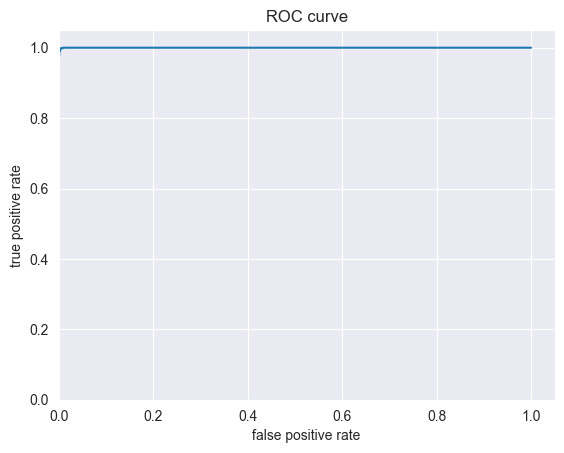

In [2060]:
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()

In [2061]:
pr, rc, _ = precision_recall_curve(y_train, predictions_proba)

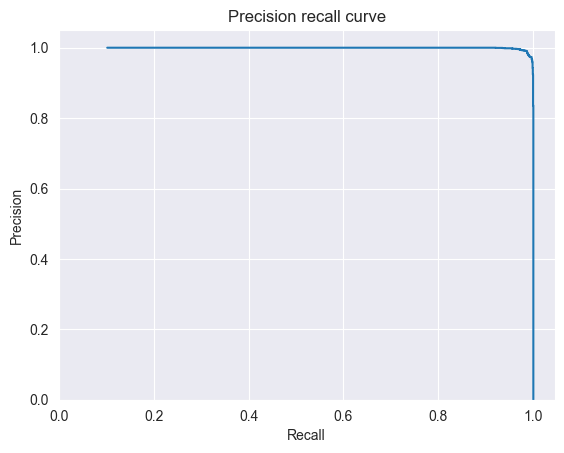

In [2062]:
plt.plot(pr, rc)
plt.title('Precision recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0,)
plt.ylim(0,)
plt.show()

Confusion Matrix


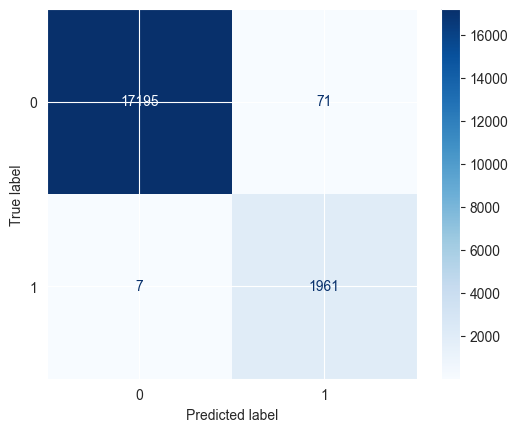

In [2063]:
print('Confusion Matrix')
conf_matrix = confusion_matrix(y_train, predictions)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

In [2114]:
export_data = pd.concat([retention_sm.user_id, pd.DataFrame(predictions_proba)], axis=1)

In [2115]:
export_data.columns = ['user_id', 'is_gone']

In [2116]:
export_data.head()

,user_id,is_gone
0,4.0,1.737603e-09
1,6.0,4.417300e-04
2,10.0,5.024700e-09
3,12.0,3.363733e-10
4,13.0,1.000000e+00


In [2117]:
export_data.to_csv('/Users/mitya/out.csv', index=False)

### Дерево решений

In [1768]:
clf = DecisionTreeClassifier()

In [1769]:
params={'criterion':['gini', 'entropy'], 'max_depth': range(5, 12)}

In [1770]:
grid_search_cv_clf=GridSearchCV(clf, params, cv=5)

In [1771]:
grid_search_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 12)})

In [1772]:
best_clf = grid_search_cv_clf.best_estimator_
best_clf

DecisionTreeClassifier(max_depth=1)

In [1773]:
grid_search_cv_clf.best_params_

{'criterion': 'gini', 'max_depth': 1}

In [1774]:
best_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=1)

In [1775]:
predictions_proba = best_clf.predict_proba(X_train)[:, 1]

In [1776]:
predictions = best_clf.predict(X_train)

In [1777]:
print('Log loss = {:.5f}'.format(log_loss(y_train, predictions_proba)))
print('AUC = {:.5f}'.format(roc_auc_score(y_train, predictions_proba)))
print('Average Precision = {:.5f}'.format(average_precision_score(y_train, predictions_proba)))
print('\nUsing 0.5 as threshold:')
print('Accuracy = {:.5f}'.format(accuracy_score(y_train, predictions)))
print('Precision = {:.5f}'.format(precision_score(y_train, predictions)))
print('Recall = {:.5f}'.format(recall_score(y_train, predictions)))
print('F1 score = {:.5f}'.format(f1_score(y_train, predictions)))

print('\nClassification Report')
print(classification_report(y_train, predictions))

Log loss = 0.28151
AUC = 0.72333
Average Precision = 0.23859

Using 0.5 as threshold:
Accuracy = 0.89768
Precision = 0.00000
Recall = 0.00000
F1 score = 0.00000

Classification Report
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     17266
           1       0.00      0.00      0.00      1968

    accuracy                           0.90     19234
   macro avg       0.45      0.50      0.47     19234
weighted avg       0.81      0.90      0.85     19234



/Users/mitya/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mitya/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mitya/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mitya/venv/lib/python3.10/site-packages/sklearn/metrics/_

Confusion Matrix


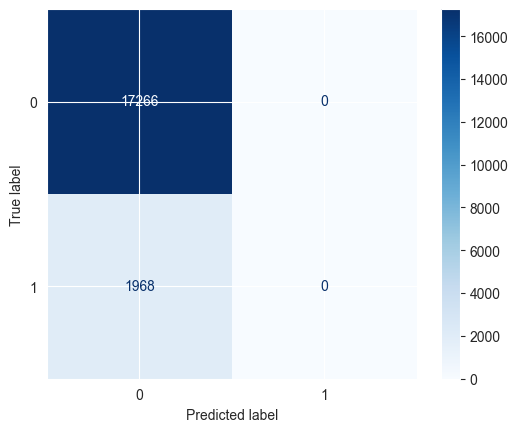

In [1767]:
plt.show()
print('Confusion Matrix')
conf_matrix = confusion_matrix(y_train, predictions)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

In [1778]:
fpr, tpr, _ = roc_curve(y_train, predictions_proba)

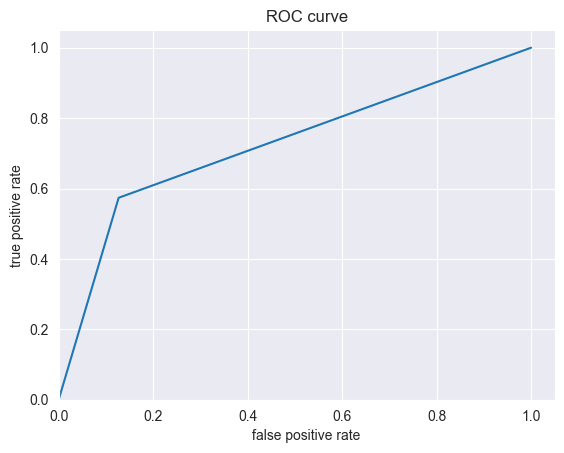

In [1779]:
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()

In [1780]:
pr, rc, _ = precision_recall_curve(y_train, predictions_proba)

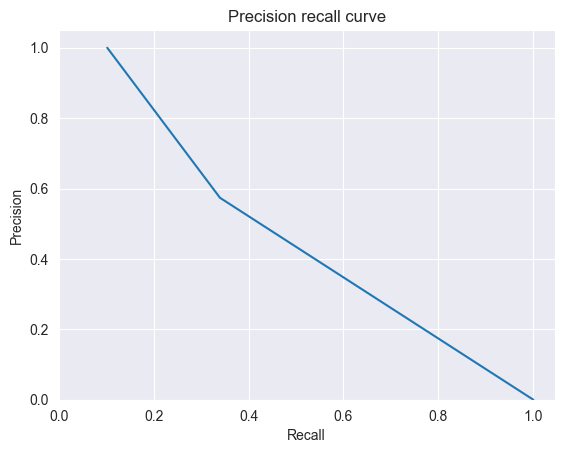

In [1781]:
plt.plot(pr, rc)
plt.title('Precision recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0,)
plt.ylim(0,)
plt.show()